In [1]:
%matplotlib inline

# Imports

In [2]:
from Bio import SeqIO
from Bio.Data import CodonTable
import glob

from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

# Get fairly independent list of proteins for analysis

There are a lot of ways to do this. I'm just showing an example from a dataset that I have previously used for different analyses which consists of ~150 highly diverged proteins.

All I'm doing is reading in the `.fasta` file that contains the proteins and extracting their sequences into a list called `all_seqs`

In [3]:
seqs_file = '../Data/example_sequences.fasta'
records = list(SeqIO.parse(seqs_file, 'fasta'))
all_seqs = [str(record.seq) for record in records]

**Inspect a few of them**

In [4]:
all_seqs[:5]

['WKSGGASHSELIHNLRKNGIIKTDKVFEVMLATDRSHYAKCNPYMDSPQSIGFQATISAPHMHAYALELLFDQLHEGAKALDVGSGSGILTACFARMVGCTGKVIGIDHIKELVDDSVNNVRKDDPTLLSSGRVQLVVGDGRMGYAEEAPYDAIHVGAAAPVVPQALIDQLKPGGRLILPVGPAGGNQMLEQYDKLQDGSIKMKPLMGVIYVPLTDKEKQWSRW',
 'LPSFVDWRSKGAVNSIKNQKQCGSCWAFSAVAAVESINKIRTGQLISLSEQELVDCDTASHGCNGGWMNNAFQYIITNGGIDTQQNYPYSAVQGSCKPYRLRVVSINGFQRVTRNNESALQSAVASQPVSVTVEAAGAPFQHYSSGIFTGPCGTAQNHGVVIVGYGTQSGKNYWIVRNSWGQNWGNQGYIWMERNVASSAGLCGIAQLPSYPTKA',
 'NMNIEEFTSGLAEKGISLSPRQLEQFELYYDMLVEWNEKINLTSITEKKEVYLKHFYDSITAAFYVDFNQVNTICDVGAGAGFPSLPIKICFPHLHVTIVDSLNKRITFLEKLSEALQLENTTFCHDRAETFGQRKDVRESYDIVTARAVARLSVLSELCLPLVKKNGLFVALKAAAEEELNAGKKAITTLGGELENIHSFKLPIEESDRNIMVIRKIKNTPKKYPRKPGTPNKSPIE',
 'MKTPRRRMRLAVFKALFQHEFRRDEDLEQILEEILDETYDKKAKEDARRYIRGIKENLSMIDDLISRYLEKWSLNRLSVVDRNVLRLATYELLFEKDIPIEVTIDEAIEIAKRYGTENSGKFVNGILDRIAKEHAPKEKFE',
 'CGIVGAIAQRDVAEILLEGLRRLEYRGYDSAGLAVVDAEGHMTRLRRLGKVQMLAQAAEEHPLHGGTGIAHTRWATHGEPSEVNAHPHVSEHIVVVHNGIIENHEPLREELKARGYTFVSETDTEVIAHLVNWELKQGGTLREAVLRAIPQLRGAYGTVI

**And double check the numbers**

In [5]:
len(all_seqs)

149

# Analyze!

**First get the `codon_to_aa_dict` and `aa_to_codon_dict` to make things easier**

In [6]:
codon_to_aa_dict = dict(CodonTable.unambiguous_dna_by_id[11].forward_table)
aa_to_codon_dict = {}
for codon,aminoacid in codon_to_aa_dict.items():
    if aminoacid not in aa_to_codon_dict.keys():
        aa_to_codon_dict[aminoacid] = []
    aa_to_codon_dict[aminoacid].append(codon)

**And make sure that it looks good**

In [7]:
aa_to_codon_dict

{'A': ['GCT', 'GCC', 'GCA', 'GCG'],
 'C': ['TGT', 'TGC'],
 'D': ['GAT', 'GAC'],
 'E': ['GAA', 'GAG'],
 'F': ['TTT', 'TTC'],
 'G': ['GGT', 'GGC', 'GGA', 'GGG'],
 'H': ['CAT', 'CAC'],
 'I': ['ATT', 'ATC', 'ATA'],
 'K': ['AAA', 'AAG'],
 'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
 'M': ['ATG'],
 'N': ['AAT', 'AAC'],
 'P': ['CCT', 'CCC', 'CCA', 'CCG'],
 'Q': ['CAA', 'CAG'],
 'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
 'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
 'T': ['ACT', 'ACC', 'ACA', 'ACG'],
 'V': ['GTT', 'GTC', 'GTA', 'GTG'],
 'W': ['TGG'],
 'Y': ['TAT', 'TAC']}

# Treat each protein as a separate possible correlation

The correlation that we care about here is between the number of codons for a particular amino acid (1,2,3,4, or 6, put in the list `x_vals`) against the frequency of that amino acid in the protein (`y_vals`). There should be ~150 different correlations and p-values that result from this analysis.

Note that our correlation method here is called Spearman's rho, which is a conservative non-paremetric correlation coefficient. That is to say, it's different from linear regression in that it doesn't assume a linear form in the relationship and is a generally more conservative statistical test. 

In [8]:
all_correlations = []
all_pvals = []
for seq in all_seqs:
    x_vals = []
    y_vals = []
    #Go through each amino acid
    for aa in aa_to_codon_dict.keys():
        #Append the number of codons for that amino acid to x_vals
        x_vals.append(len(aa_to_codon_dict[aa]))
        #And the number of that amino acid in the sequence divided by the total sequence length to y_vals
        y_vals.append(seq.count(aa)/len(seq))
    #Perform a non-parametric correlation
    single_corr, single_p = stats.spearmanr(x_vals, y_vals)
    all_correlations.append(single_corr)
    all_pvals.append(single_p)

**Look at a single example (based on the above code this just looks at the last protein in the list)**

This is the basic correlation data that we performed for all ~150 proteins but it's always good to see an example

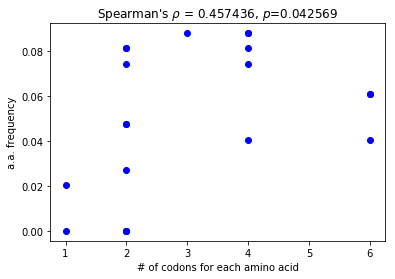

In [9]:
fig, ax = plt.subplots()
ax.plot(x_vals, y_vals, 'bo')
ax.set_xlabel('# of codons for each amino acid')
ax.set_ylabel('a.a. frequency')
ax.set_title(r"Spearman's $\rho$ = {:f}, $p$={:f}".format(single_corr,single_p))
plt.savefig('../temp_fig.png')

** Looking at the aggregated results for all proteins**

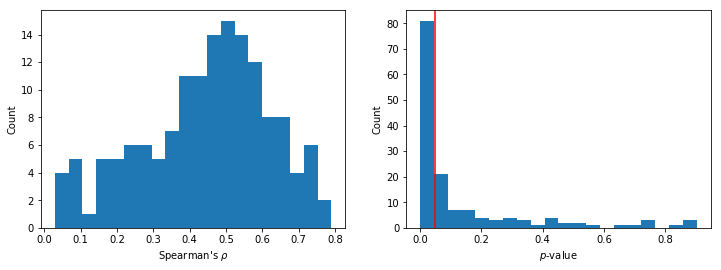

In [10]:
fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax_arr[0].hist(all_correlations, 20)
ax_arr[0].set_xlabel(r"Spearman's $\rho$")
ax_arr[0].set_ylabel('Count')
ax_arr[1].hist(all_pvals, 20)
ax_arr[1].axvline(0.05, color='r')
ax_arr[1].set_xlabel(r"$p$-value")
ax_arr[1].set_ylabel('Count')
plt.savefig('../temp_fig.png')

**And some summary statistics of those findings**

In [12]:
print('Mean correlation:', np.mean(all_correlations), '\n',\
      'Median correlation:', np.median(all_correlations), '\n',\
      'Number of significant correlations:', len([i for i in all_pvals if i < 0.05]), '\n',\
      'Total number or correlations assessed:', len(all_pvals), '\n',\
     'Median p-value:', np.median(all_pvals))

Mean correlation: 0.44563894979589025 
 Median correlation: 0.46277296502712406 
 Number of significant correlations: 84 
 Total number or correlations assessed: 149 
 Median p-value: 0.03991152690724015


** This is a little weeds-y, but we can combine p-values using a standard method from each of these (assumed to be independent) p-values to determine an overall p-value for the set of proteins:**

In [13]:
test_stat, meta_p = stats.combine_pvalues(all_pvals, method='fisher')

print(meta_p)

1.4521055606224586e-84


Let's parse that p-value out a bit. Under the null hypothesis (that there is no relationship between codon number per amino acid and the frequency of amino acids used in a protein), we would expect to observe correlations this strong (or stronger) with a probability of ~10\*\*-84. So, basically never.

Another (more colloquial) way of putting that p-value into context is that if nothing interesting was happening, we'd have to look at ~10\*\*84 similar observations (sets of correlations from ~150 proteins) to observe a set of correlations this large (having 84 out of 149 be independently significant). Ergo, it's really unlikely that nothing interesting is happening. I stress this because it's important to note that this finding/p-value makes no statement about the probability that our hypothesis is correct. Lot's of other things could be going on here and we need to be precise with our interpretation of p-values. But what we can say, is that the probability that nothing interesting is happening is virtually zero. 

# Alternatively, instead of treating each protein independently we could look at them all combined 

**(by concatenating all proteins together into one big super-protein)**

Ideologically, this is a completely different way of looking at the problem. Either approach could arguably be called "correct" (though I much prefer the previous way), they just make different assumptions (and as you'll see this method is much more conservative and still results in a signficant relationship)

In [14]:
all_seqs_concat = ''.join(all_seqs)
all_len = len(all_seqs_concat)
x_vals = []
y_vals = []
for aa in aa_to_codon_dict.keys():
    x_vals.append(len(aa_to_codon_dict[aa]))
    y_vals.append(all_seqs_concat.count(aa)/all_len)
combined_corr, combined_p = stats.spearmanr(x_vals, y_vals)
print(combined_corr, combined_p)

0.6515808441958317 0.001855385400217122


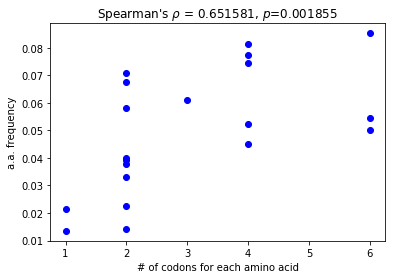

In [15]:
fig, ax = plt.subplots()
ax.plot(x_vals, y_vals, 'bo')
ax.set_xlabel('# of codons for each amino acid')
ax.set_ylabel('a.a. frequency')
ax.set_title(r"Spearman's $\rho$ = {:f}, $p$={:f}".format(combined_corr,combined_p))
plt.savefig('../temp_fig.png')

The p-value here is much larger. Why? In the previous method (that I prefer) we are actually saying something equivalent to this:

Okay so you flipped a nickel 10 times and got 6 heads. No big deal right? I mean, it wouldn't be surprising to find out that the nickel is completely unbiased and the p-value for 6 heads out of 10 flips is definitely  not significant in the least bit. But what if I had 150 people flip nickels ten times and all of them got 6 heads out of 10? Well, even though no single one of them has the statistical power to say that nickels are biased, in aggregate we are pretty sure that there is something strange going on with nickels.

In this latter analysis, it's more like you flip a nickel 150\*10=1500 times. And you get 150\*6=900 heads. Statistically, the overall p-value might still be significant (we observed 900 heads but we only expected to observe ~750) but we maybe shouldn't expect the p-value to be identical to the first method. After all, you're flipping *one* nickel and maybe there is something wrong with you and/or that single nickel that you happened to have in your pocket. We are much more confident (and have the statistical power to assign smaller p-values as a result) in the former case because we kind of have 150 *different* people flipping 150 *different* nickels. So as a statement about nickels in general, this first case is a much more powerful way to test a hypothesis about nickels compared to the case where you tediously flip a single nickel 1500 times.

That all said, it's still re-assuring that in this combined analysis of proteins the p-value is nevertheless still < 0.01 and this should give us confidence that we're on to something. Of course, that something has been known for a long time but this should serve as the fundamental motivation for the project.

# Scratch